### Model Training Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
cd ..

c:\Users\Matheus\Documents\Git\knowledge-graph-completion


#### Bart Example

In [3]:
# from transformers import BartForConditionalGeneration, BartTokenizer

# model = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0)
# tok = BartTokenizer.from_pretrained("facebook/bart-large")
# example_english_phrase = "Dominican Republic has form of government of <mask>"
# batch = tok(example_english_phrase, return_tensors="pt")
# generated_ids = model.generate(batch["input_ids"])
# tok.batch_decode(generated_ids, skip_special_tokens=True)

### Load data

In [4]:
import pandas as pd
from src.utils import load_fb15k237

PATH_FB15k237 = "data/datasets_knowledge_embedding/FB15k-237"

train, valid, test, entity2wikidata = load_fb15k237(PATH_FB15k237)
processed_data = pd.read_csv(PATH_FB15k237 + "/processed_data.csv")

### Load the model

In [5]:
from transformers import (
    BartForConditionalGeneration,
    BartTokenizer,
    BartConfig,
    DataCollatorForSeq2Seq,
)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEV_BATCH = 1600
MAX_LENGTH = 32
BATCH_SIZE = 8

# Select model
# MODEL = "facebook/bart-large"
# MODEL = "facebook/bart-base"
MODEL = "lucadiliello/bart-small"

# Load model and tokenizer
model = BartForConditionalGeneration.from_pretrained(MODEL).cuda().float().to(device)
tok = BartTokenizer.from_pretrained(MODEL)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


### Some tests

In [6]:
# sample = processed_data.iloc[5]

# text_sample = sample.demonstration_input + sample.tail_text + "."
# print(text_sample)

# to_mask = sample.tail_text
# print(to_mask)

# ids_to_mask = tok.convert_tokens_to_ids(to_mask)
# print(ids_to_mask)
# print(tok.convert_ids_to_tokens(ids_to_mask))

# print(
#     tok.encode(
#         "i want to mask Hello world",
#         add_special_tokens=True,
#         max_length=MAX_LENGHT,
#         truncation=True,
#         padding="max_length",
#     )[:10]
# )

# print(
#     tok.encode(
#         "i want to mask <mask>",
#         add_special_tokens=True,
#         max_length=MAX_LENGHT,
#         truncation=True,
#         padding="max_length",
#     )[:10]
# )

# print(tok.all_special_tokens)
# print(tok.all_special_ids)

# tok.mask_token_id#

### Masking data

In [7]:
processed_data["data_input"] = (
    processed_data["demonstration_input"] + "%s." % tok.mask_token
)
processed_data["data_label"] = (
    processed_data["demonstration_input"] + processed_data["tail_text"] + "."
)

In [8]:
dev = True

if dev:
    if DEV_BATCH == -1:
        pass
    else:
        processed_data = processed_data.head(DEV_BATCH)

In [9]:
from torch.utils.data import Dataset
import copy
import random


class DatasetKGC(Dataset):
    def __init__(self, data):
        self.data = data
        self.data["input_ids"] = self.data["input_ids"]
        self.data["labels"] = self.data["labels"]
        self.num_rows = self.data["input_ids"].shape[0]

    def __len__(self):
        return self.num_rows

    def __getitem__(self, idx):
        _input = self.data["input_ids"][idx].squeeze(0)
        label = self.data["labels"][idx].squeeze(0)

        return (_input, label)

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding

import random

random.seed(42)


def encode_data(data):
    # Codifica as strings de entrada e rótulos como sequências de tokens BART
    encoded_input = tok(
        list(data["data_input"]),
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        return_attention_mask=False,
    )
    encoded_label = tok(
        list(data["data_label"]),
        padding="max_length",
        truncation=True,
        return_tensors="pt",
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        return_attention_mask=False,
    )

    # Cria uma lista de exemplos
    examples = []
    for i in range(len(data)):
        input_ids = encoded_input["input_ids"][i]
        labels = encoded_label["input_ids"][i]
        examples.append({"input_ids": input_ids, "labels": labels})

    # Cria um objeto DataCollatorForLanguageModeling
    data_collator = DataCollatorWithPadding(
        tokenizer=tok, padding="max_length", max_length=MAX_LENGTH
    )

    # Prepara os dados de treinamento
    prepared_data = data_collator(examples)

    return prepared_data


def train_valid_split(data):
    train, valid = train_test_split(data, test_size=0.2, random_state=42)
    return encode_data(train), encode_data(valid)


def generate_train_valid_dataloader(data):
    train, valid = train_valid_split(data)

    train_loader = DataLoader(DatasetKGC(train), batch_size=BATCH_SIZE, shuffle=False)

    valid_loader = DataLoader(DatasetKGC(valid), batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, valid_loader

### Training Model

In [11]:
train_loader, valid_loader = generate_train_valid_dataloader(processed_data)

In [ ]:
# Test batch shape
train_features, train_labels = next(iter(train_loader))
print(f"Train Feature batch shape: {train_features.size()}")
print(f"Train Labels batch shape: {train_labels.size()}\n")

valid_features, valid_labels = next(iter(valid_loader))
print(f"Valid Feature batch shape: {valid_features.size()}")
print(f"Valid Labels batch shape: {valid_labels.size()}")

In [ ]:
# for _input, label in valid_loader:
#     print(tok.decode(_input[1]))
#     print()
#     print(tok.decode(label[1]))
#     break

In [12]:
def _decode(tokens, tokenizer=tok, batch=True):
    # Remove padding tokens and decode
    # tokens = tokens[tokens != -100]
    if batch:
        return tokenizer.batch_decode(tokens, skip_special_tokens=True)

    return tokenizer.decode(tokens, skip_special_tokens=True)


def _decode_error(tokens_i, tokens_j, tokenizer=tok):
    """ """
    # Remove padding tokens
    text_i = _decode(tokens_i)
    text_j = _decode(tokens_j)

    # print(text_i)
    # print(text_j)

    error = 0

    len_i = len(tokens_i)
    len_j = len(tokens_j)
    total_tokens = max(len_i, len_j)

    diff_shape = abs(len_i - len_j)

    error += diff_shape

    for i in range(min(len_i, len_j)):
        if text_i[i] != text_j[i]:
            error += 1

    return (error, total_tokens, error / total_tokens)

In [ ]:
_decode_error(valid_features[1], valid_labels[1])

In [ ]:
for _input, label in valid_loader:
    _input_text = tok.decode(_input[0], skip_special_tokens=True)
    label_text = tok.decode(label[0], skip_special_tokens=True)
    model_output = model.generate(_input.to(device), max_length=MAX_LENGTH)[0]

    print("Input: %s" % _input_text)
    print("Expected Output: %s" % label_text)
    print("Model Output: %s" % tok.decode(model_output, skip_special_tokens=True))
    a, b, percentage = _decode_error(_input[0], model_output.to("cpu"))
    print("Error rate per token: %.3f" % percentage)
    print(a, b)

    break

In [ ]:
from tqdm.auto import tqdm

error_tokens = 0
total_tokens = 0

for _input, label in tqdm(valid_loader):
    model_output = model.generate(_input.to(device), max_length=MAX_LENGTH)

    for i in range(len(model_output)):
        a, b, percentage = _decode_error(label[i], model_output[i].to("cpu"))
        error_tokens += a
        total_tokens += b

print("Total tokens analyzed: %d" % total_tokens)
print("Total erroneous tokens predicted: %d" % error_tokens)
print("Percentage of error: %.3f%%" % (error_tokens / total_tokens * 100))

In [13]:
from tqdm.auto import tqdm


def _decode_error_epoch(model, valid_dataset, debug=False):
    error_tokens = 0
    total_tokens = 0

    with torch.no_grad():
        for _input, label in tqdm(valid_dataset, desc="Analyzing decoder error"):
            model_output = model.generate(_input.to(device), max_length=MAX_LENGTH)

            for i in range(len(model_output)):
                a, b, percentage = _decode_error(label[i], model_output[i].to("cpu"))
                error_tokens += a
                total_tokens += b

        if debug:
            print("Total tokens analyzed: %d" % total_tokens)
            print("Total erroneous tokens predicted: %d" % error_tokens)
            print("Percentage of error: %.3f%%" % ((error_tokens / total_tokens) * 100))

        return error_tokens, total_tokens, error_tokens / total_tokens

In [ ]:
_decode_error_epoch(model, valid_loader)

In [15]:
# Setup
from transformers import AdamW, get_scheduler

epochs = 15
epoch_accuracy_frequency = 5  # if epoch % accuracy -> compute
loss_epoch = []
lr = 1e-4
cross = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
# Train

from tqdm.auto import tqdm

pbar = tqdm(range(1, epochs + 1), desc="Epochs")
decoder_error = []

decoder_error.append(_decode_error_epoch(model, valid_loader, debug=True))

for epoch in pbar:
    epoch_loss = 0

    pbar.set_description("Epoch %s" % epoch)
    pbar.refresh()

    print("EPOCH %d" % epoch)

    for _input, label in tqdm(train_loader):
        model.zero_grad()

        _dt = model(_input.to(device), return_dict=True)

        logits = _dt.logits
        loss = cross(logits.view(-1, logits.size(-1)), label.to(device).view(-1))

        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % epoch_accuracy_frequency == 0:
        decoder_error.append(_decode_error_epoch(model, valid_loader, debug=True))

    pbar.set_postfix(loss=epoch_loss)
    loss_epoch.append(epoch_loss)

    torch.cuda.empty_cache()

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Analyzing decoder error:   0%|          | 0/40 [00:00<?, ?it/s]

Total tokens analyzed: 10240
Total erroneous tokens predicted: 9476
Percentage of error: 92.539%
EPOCH 1


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 2


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 3


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 4


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 5


  0%|          | 0/160 [00:00<?, ?it/s]

Analyzing decoder error:   0%|          | 0/40 [00:00<?, ?it/s]

Total tokens analyzed: 10240
Total erroneous tokens predicted: 9193
Percentage of error: 89.775%
EPOCH 6


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 7


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 8


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 9


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 10


  0%|          | 0/160 [00:00<?, ?it/s]

Analyzing decoder error:   0%|          | 0/40 [00:00<?, ?it/s]

Total tokens analyzed: 10240
Total erroneous tokens predicted: 9575
Percentage of error: 93.506%
EPOCH 11


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 12


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 13


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 14


  0%|          | 0/160 [00:00<?, ?it/s]

EPOCH 15


  0%|          | 0/160 [00:00<?, ?it/s]

Analyzing decoder error:   0%|          | 0/40 [00:00<?, ?it/s]

Total tokens analyzed: 10240
Total erroneous tokens predicted: 9680
Percentage of error: 94.531%


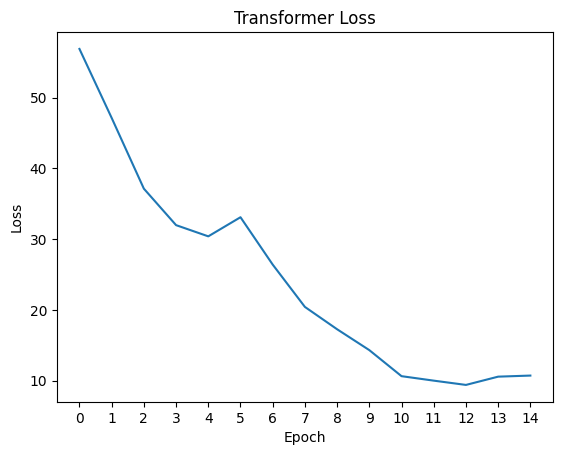

In [17]:
import matplotlib.pyplot as plt

plt.title("Transformer Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(epochs + 1))
plt.plot(loss_epoch)

In [23]:
epochs / epoch_accuracy_frequency

3.0

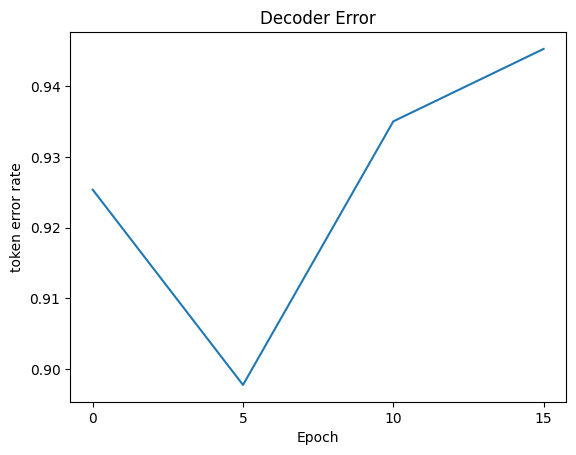

In [41]:
import matplotlib.pyplot as plt

plt.title("Decoder Error")
plt.xlabel("Epoch")
plt.ylabel("token error rate")
plt.xticks(
    list(map(lambda i: i * epoch_accuracy_frequency, list(range(len(decoder_error)))))
)
plt.plot(
    list(map(lambda i: i * epoch_accuracy_frequency, list(range(len(decoder_error))))),
    [i[2] for i in decoder_error],
)